In [1]:
%load_ext autoreload
%autoreload 2

import random
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
pd.options.display.max_rows = None

/home/chenzhil/miniconda3/envs/convPlan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import _csv
with open("LMSYS_testing_HUMAN_TRANSITIONS.csv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for i, line in enumerate(reader):
        print(i)
        print(line)
        if i > 10: 
            break

FileNotFoundError: [Errno 2] No such file or directory: 'LMSYS_testing_HUMAN_TRANSITIONS.csv'

In [ ]:
from data_preprocessing import *

import sys
import csv

csv.field_size_limit(sys.maxsize)

X,y = get_mistral_harm_data("data/LMSYS_mistral.csv_MODERATION_SCORES.csv")

from torch.utils.data import random_split
import pickle
dataset = DailyDialogueTransitionData(X, y)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# # Split the dataset randomly
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Save the dataset object
with open('LMSYS_transition_dataset_train_MISTRAL_LLM.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)
    
with open('LMSYS_transition_dataset_validaton_MISTRAL_LLM.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)

# print("Dataset saved successfully.")


In [ ]:
from data_preprocessing import *
from transition_models.transition_data import DailyDialogueTransitionData
from torch.utils.data import DataLoader, Dataset

import sys
import csv

csv.field_size_limit(sys.maxsize)


X,y = get_mistral_harm_data("data/nomic/LMSYS_nomic.csv_MODERATION_SCORES.csv")
dataset = DailyDialogueTransitionData(X, y)



In [ ]:
from transition_models.transition_data import DailyDialogueTransitionData
dataset = DailyDialogueTransitionData(X, y)

from torch.utils.data import random_split
import pickle
dataset = DailyDialogueTransitionData(X, y)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# # Split the dataset randomly
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
from torch.utils.data import random_split
import pickle
dataset = DailyDialogueTransitionData(X, y)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# # Split the dataset randomly
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Save the dataset object
with open('data/mistral/moderation_scores_train.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)
    
with open('data/mistral/moderation_scores_validation.pkl', 'wb') as f:
    pickle.dump(val_dataset, f)

print("Dataset saved successfully.")

Dataset saved successfully.


In [ ]:
import pickle 
with open('data/nomic/LMSYS_transition_dataset_train_NOMIC_Human.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open('data/nomic/LMSYS_transition_dataset_validaton_NOMIC_Human.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

In [ ]:

from transition_models.transition_data import DailyDialogueTransitionData

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle

with open('data/nomic/LMSYS_transition_dataset_train_NOMIC_Human.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open('data/nomic/LMSYS_transition_dataset_validaton_NOMIC_Human.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

from transition_models.deterministic_transition_model import DeterministicTransitionModel
#768
#4096
dim = 768
device = torch.device('cuda:0')
transition = DeterministicTransitionModel(dim, samples=1, cuda=device)
t,v = transition.train_llm_transition(train_loader, val_loader, path_to_save=None, lr=0.0001, num_epochs=500)



In [ ]:
import pickle 
with open('data/daily_dialogue_transition_dataset_train_MISTRAL.pkl', 'rb') as f:
    daily_train_dataset = pickle.load(f)

with open('data/daily_dialogue_transition_dataset_validation_MISTRAL.pkl', 'rb') as f:
    daily_val_dataset = pickle.load(f)

In [ ]:
from transition_models.transition_data import DailyDialogueTransitionData

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

train_loader = DataLoader(daily_train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(daily_val_dataset, batch_size=256, shuffle=True)

from transition_models.deterministic_transition_model import DeterministicTransitionModel

dim = 4096
device = torch.device('cuda:0')
transition = DeterministicTransitionModel(dim, samples=1, cuda=device)
t,v = transition.train_env_transition(train_loader, val_loader, lr=0.001, num_epochs=500)



In [ ]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def obj_function(lr):
    print("trying out lr", lr)
    dim = 4096
    device = torch.device('cuda:5')
    transition = DeterministicTransitionModel(dim, device)
    t,v = transition.train_llm_transition(train_loader, val_loader, num_epochs=1000, lr=lr[0])
    best_validation_loss = min(v)
    return best_validation_loss

space = [
    Real(0.0001, 0.01)
]

res = gp_minimize(obj_function,                  # the function to minimize
                  space,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=10,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  random_state=1234)   # the random seed

In [ ]:
train_size = int(0.1 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# # Split the dataset randomly
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

x_split, y_split = train_dataset[:]

torch.Size([7605, 4096])
torch.Size([7605, 4096])


In [ ]:
import torch
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood, SumMarginalLogLikelihood, MarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.models import SingleTaskGP, HeteroskedasticSingleTaskGP, KroneckerMultiTaskGP, MultiTaskGP, HeteroskedasticSingleTaskGP
from torch.optim import SGD
import time

dataset = DailyDialogueTransitionData(X, y)


for percentage_training in [0.01,0.05,0.1,0.15,0.2]:
    start = time.process_time()
    train_size = int(percentage_training * len(dataset))  # 80% for training
    val_size = len(dataset) - train_size  # Remaining 20% for validation

    # # Split the dataset randomly
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    x_split, y_split = train_dataset[:]
    
    print("number of datapt: ", len(x_split))
    device = torch.device('cuda:5')
    gp = KroneckerMultiTaskGP(x_split.to(device), y_split.to(device))
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    mll.to(x_split)
    

    optimizer = SGD([{'params': gp.parameters()}], lr=0.1)
    
    NUM_EPOCHS = 150

    gp.train()

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output = gp(x_split)
        # Compute negative marginal log likelihood
        loss = - mll(output, y_split)
        # back prop gradients
        loss.backward()
        # print every 10 iterations
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
                f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
                f"noise: {gp.likelihood.noise.item():>4.3f}" 
            )
        optimizer.step()   
        
        print("time taken to fit multi output gp: ", time.process_time() - start)  

#posterior = gp.posterior(test_X)

In [ ]:
# read from dataset
conversation_data = pd.read_parquet('human_llm_convo.parquet', engine='auto')

In [ ]:
# read from dataset
conversation_data = pd.read_parquet('human_llm_convo.parquet', engine='auto')
english_convo = conversation_data.loc[conversation_data['language'] == "English"]
long_convo = english_convo.loc[english_convo['turn'] > 2]
convo_starter_english = [x[0]['content'] for x in list(long_convo.conversation)]
convo_starter_filtered = [x for x in convo_starter_english if len(x) > 20 and len(x) < 200]
convo_starter_filtered = [x for x in convo_starter_filtered if not ("NAME_1" in x or "NAME_2" in x)]

In [ ]:

category = list(conversation_data.openai_moderation[3][0]['categories'].keys())

['harassment', 'harassment/threatening', 'hate', 'hate/threatening', 'self-harm', 'self-harm/instructions', 'self-harm/intent', 'sexual', 'sexual/minors', 'violence', 'violence/graphic']


In [ ]:
conversation_data.openai_moderation[3][0]

{'categories': {'harassment': False,
  'harassment/threatening': False,
  'hate': False,
  'hate/threatening': False,
  'self-harm': False,
  'self-harm/instructions': False,
  'self-harm/intent': False,
  'sexual': False,
  'sexual/minors': False,
  'violence': False,
  'violence/graphic': False},
 'category_scores': {'harassment': 4.2268514e-08,
  'harassment/threatening': 1.968493e-09,
  'hate': 1.574229e-08,
  'hate/threatening': 9.697849e-11,
  'self-harm': 4.6034412e-11,
  'self-harm/instructions': 8.869029e-12,
  'self-harm/intent': 8.679583e-13,
  'sexual': 4.3375917e-07,
  'sexual/minors': 5.3620926e-07,
  'violence': 2.966025e-06,
  'violence/graphic': 1.4624901e-06},
 'flagged': False}

In [ ]:
cuda4 = torch.device('cuda:4')
# load model and tokenizer

from transition_models.embedding_model import *
from transformers import AutoTokenizer, BertModel

tokenizer = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-Mistral')
model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-Mistral').to(cuda4)
print("finished loading from pretrained")

embed_model = embedding_model(tokenizer, model, cuda4)
# embedding = embed_model.embed("hello how are you")

/home/chenzhil/miniconda3/envs/convPlan/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


finished loading from pretrained


In [ ]:

    
def extract_semantic_embedding_human_llm_dialogue(conversation_data, output_name, embedding_model):
    llm_transition_data = [] # response of LLM
    env_transition_data = [] # response of human
    moderation_score_data = []
    count = 0
    for convo, moderation_score in zip(conversation_data.conversation, conversation_data.openai_moderation):
        if len(convo) < 2:
            continue
        s1 = ""
        for idx in range(len(convo)-1):
            row_data = []
            row_data_llm = []
            row_data_env = []
            row_data_moderation = []

            s1 = s1 + " " + convo[idx]["content"]
            s2 = s1 + " " + convo[idx+1]["content"]
            
            s1_embedding = embedding_model.embed(s1).detach().cpu().numpy()
            s2_embedding = embedding_model.embed(s2).detach().cpu().numpy()
            
            transition_embedding = np.concatenate([s1_embedding, s2_embedding])
            
            row_data.append(s1)
            row_data.append(s2) # sentence
            
            if idx % 2 == 1: # if human is s1, llm is s2
                row_data_llm = row_data + list(transition_embedding)
            if idx % 2 == 0: # llm is s1, human is s2
                row_data_env = row_data + list(transition_embedding)
            
                
            harmful_score = moderation_score[idx]['category_scores']
            print(harmful_score)
            row_data_moderation = row_data + [harmful_score["harassment"]] + [harmful_score["hate"]] + [harmful_score["sexual"]] + [harmful_score["violence"]] + list(transition_embedding)
                
            llm_transition_data.append(row_data_llm)
            env_transition_data.append(row_data_env)
            moderation_score_data.append(row_data_moderation)
        count += 1
        if count > 10:
            break

    import csv
    with open(output_name + "_LLM_TRANSITIONS.csv", 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(llm_transition_data)

    with open(output_name + "_HUMAN_TRANSITIONS.csv", 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(env_transition_data)

    with open(output_name + "_MODERATION_SCORES.csv", 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(moderation_score_data)

In [ ]:
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel


# load model and tokenizer
#tokenizer1 = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-Mistral')
#tokenizer2 = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
#model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-Mistral').to(torch.device('cuda:'+str(1)))
# print("finished loading from pretrained")
# embed_model = embedding_model_mistral(tokenizer, model, False, torch.device('cuda:'+str(2)))

print(model(**(tokenizer1("hi how are you?", return_tensors='pt').to(torch.device('cuda:'+str(1))))))



In [ ]:

extract_semantic_embedding_human_llm_dialogue(english_convo, "LMSYS_transition_Mistral", embed_model)

In [ ]:
conversation_data = pd.read_parquet('daily_dialogue.parquet', engine='auto')

In [ ]:
convo = ["[YOU]: "+x[0] for x in list(conversation_data.dialog)]
convo_chosen = random.choices(convo,k=100)

In [ ]:

with open("evaluation/evaluation_starters_100.txt", mode="w") as file:
    file.write("\n".join(convo_chosen) + "\n")


In [ ]:
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

# Each query must come with a one-sentence instruction that describes the task
task = 'Given a web search query, retrieve relevant passages that answer the query'
queries = [
    get_detailed_instruct(task, 'How to bake a chocolate cake'),
    get_detailed_instruct(task, 'Symptoms of the flu')
]
# No need to add instruction for retrieval documents
passages = [
    "To bake a delicious chocolate cake, you'll need the following ingredients: all-purpose flour, sugar, cocoa powder, baking powder, baking soda, salt, eggs, milk, vegetable oil, and vanilla extract. Start by preheating your oven to 350°F (175°C). In a mixing bowl, combine the dry ingredients (flour, sugar, cocoa powder, baking powder, baking soda, and salt). In a separate bowl, whisk together the wet ingredients (eggs, milk, vegetable oil, and vanilla extract). Gradually add the wet mixture to the dry ingredients, stirring until well combined. Pour the batter into a greased cake pan and bake for 30-35 minutes. Let it cool before frosting with your favorite chocolate frosting. Enjoy your homemade chocolate cake!",
    "The flu, or influenza, is an illness caused by influenza viruses. Common symptoms of the flu include a high fever, chills, cough, sore throat, runny or stuffy nose, body aches, headache, fatigue, and sometimes nausea and vomiting. These symptoms can come on suddenly and are usually more severe than the common cold. It's important to get plenty of rest, stay hydrated, and consult a healthcare professional if you suspect you have the flu. In some cases, antiviral medications can help alleviate symptoms and reduce the duration of the illness."
]

In [ ]:
cuda4 = torch.device('cuda:4')
# load model and tokenizer

from transition_models.embedding_model import *

tokenizer = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-Mistral')
model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-Mistral').to(cuda4)
print("finished loading from pretrained")

embed_model = embedding_model(tokenizer, model, cuda4)
embedding = embed_model.embed("hello how are you")

In [ ]:
embed_model = embedding_model(tokenizer, model, cuda4)
embedding = embed_model.embed("hello how are you")
    

NameError: name 'cuda4' is not defined

In [ ]:
embedding.detach().cpu().numpy().shape

(4096,)

In [ ]:

def extract_semantic_embedding(conversation_data, output_name, embedding_model):
    data = []
    for idx_convo, convo in enumerate(conversation_data.dialog):
        print("convo idx: ", idx_convo)
        if len(convo) < 2:
            continue
        s1 = ""
        for idx in range(len(convo)-1):
            row_data = []
            s1 = s1 + " " + convo[idx]
            s2 = s1 + " " + convo[idx+1]
            
            s1_embedding = embedding_model.embed(s1).detach().cpu().numpy()
            s2_embedding = embedding_model.embed(s2).detach().cpu().numpy()
            
            transition_embedding = np.concatenate([s1_embedding, s2_embedding])
            
            row_data.append(s1)
            row_data.append(s2)
            row_data += list(transition_embedding)
            data.append(row_data)
        if idx_convo > 1:
            break

    import csv
    with open(output_name, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)

extract_semantic_embedding(conversation_data, "daily_dialogue_transition_Mistral.csv", embed_model)

In [ ]:
from transformers import AutoTokenizer, BertModel
import torch

# Bert embedding. Just an example of how an semantic embedding is generated.
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model_bert = BertModel.from_pretrained("google-bert/bert-base-uncased")
text = "sentence to extract embeddinsdadasdasdasdasd asdsdas dasd sdsdg from."
encoded_input = tokenizer(text, return_tensors='pt')
output = model_bert(**encoded_input).last_hidden_state

In [ ]:
# read from dataset
conversation_data = pd.read_parquet('data/human_llm_convo.parquet', engine='auto')

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from semantic_space_utils import *

# embedding is already generated in the csv files. Let's visualize them in 2D after PCA.
all_embedding=np.loadtxt("data/3_embedding_all_convo.csv",delimiter=",")
pca = PCA(n_components=2)
all_embedding_reduced_dim = pca.fit_transform(all_embedding)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
all_embedding_reduced_dim = pca.fit_transform(all_embedding)
tokenizer = AutoTokenizer.from_pretrained('Salesforce/SFR-Embedding-Mistral')
model = AutoModel.from_pretrained('Salesforce/SFR-Embedding-Mistral').to(torch.device("cpu"))
print("finished loading from pretrained")

/home/chenzhil/miniconda3/envs/convPlan/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

finished loading from pretrained


In [ ]:
conversation_data.head(20)

,conversation_id,model,conversation,turn,language,openai_moderation,redacted
0,33f01939a744455c869cb234afca47f1,wizardlm-13b,[{'content': 'how can identity protection serv...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
1,1e230e55efea4edab95db9cb87f6a9cb,vicuna-13b,[{'content': 'Beside OFAC's selective sanction...,6,English,"[{'categories': {'harassment': False, 'harassm...",False
2,0f623736051f4a48a506fd5933563cfd,vicuna-13b,[{'content': 'You are the text completion mode...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
3,e5c923a7fa3f4893beb432b4a06ef222,palm-2,[{'content': 'The sum of the perimeters of thr...,2,English,"[{'categories': {'harassment': False, 'harassm...",False
4,8ad66650dced4b728de1d14bb04657c1,vicuna-13b,[{'content': 'What is the type of the variable...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
5,aa041ed88edd4100bde61b8d68fc7288,wizardlm-13b,[{'content': 'I have 1000 documents to downloa...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
6,113d3ddd85874229a04a660bc629c2cc,vicuna-13b,"[{'content': 'summarise below transcript ""Stud...",1,English,"[{'categories': {'harassment': False, 'harassm...",False
7,4c95520511844ca492ad9ec1cb3672e3,llama-2-13b-chat,[{'content': 'Определи важнейшие смыслы в текс...,3,unknown,"[{'categories': {'harassment': False, 'harassm...",False
8,64f322dcb69d43229bbd9785b7d90f1b,vicuna-13b,"[{'content': 'Buenas noches!', 'role': 'user'}...",8,Spanish,"[{'categories': {'harassment': False, 'harassm...",False
9,6fc9a36392e94a83939dc3738ab9e245,vicuna-13b,[{'content': 'hola puedes hablar español de ar...,5,Spanish,"[{'categories': {'harassment': False, 'harassm...",False


(19, 768)
(19, 2)
[[ 1.6167562   1.30686297]
 [ 1.2317619   1.32365214]
 [ 0.75932225  1.26786715]
 [ 0.90799875  1.51227653]
 [-0.20919858  1.40868253]
 [-0.53900035  1.44652424]
 [-0.65479821  1.34948595]
 [-0.66219326  1.42639866]
 [-0.64036993  1.50907764]
 [-0.67518635  1.51443076]]
[[ 2.5319962   1.3537751 ]
 [ 0.75992056  1.23492595]
 [ 1.15885134  1.56458318]
 [-0.10951082  1.44708974]
 [-0.50671008  1.3926977 ]
 [-0.4558394   1.42244875]
 [-0.7411066   1.35013398]
 [-0.58978263  1.43676161]
 [-0.6721397   1.51495902]]
['Can you write a sentence with information from these words? reason for recruitment , recruitment reason , recruiting reason , attribute'
 "The reason for the recruitment of the new employee was due to the company's need to fill the position with someone who possessed the necessary attributes for success in the role."
 'Can you write a sentence to summarize information from these words? reason for recruitment , recruitment reason , recruiting reason , attribute'

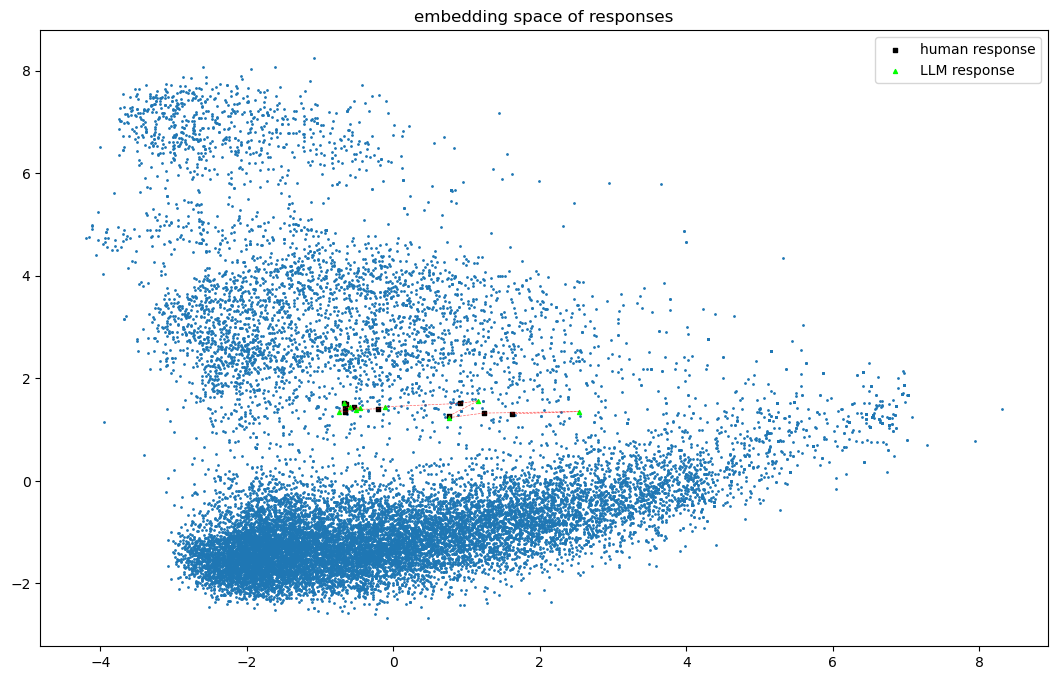

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from semantic_space_utils import *

visualize_convo(162325, all_embedding_reduced_dim, conversation_data, model_bert, tokenizer, pca, plot_points="per_conversation_context")
plt.savefig("semantic_embedding", dpi=1000)


## Create humans based on LLM

In [3]:
import openai
import yaml
from agent.Agent import *

human, llm_agent = create_human_and_llm()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Initialized Human as local model: meta-llama/Meta-Llama-3-8B-Instruct.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Initialized LLM as local model: meta-llama/Meta-Llama-3-8B-Instruct.


# Perform MCTS on response space to learn a Q function

In [1]:
from monte_carlo_tree_search.gridworld import *
from graph_visualisation import GraphVisualisation
from monte_carlo_tree_search.qtable import QTable, DeepQFunction, ReplayBufferDeepQFunction
from monte_carlo_tree_search.single_agent_mcts import SingleAgentMCTS
from monte_carlo_tree_search.conversation_env import conversation_environment
from monte_carlo_tree_search.ucb import UpperConfidenceBounds

conversation_env = conversation_environment(human, llm_agent, "Tell me something about Singapore.", max_depth=5)

# choose the Q function (we use neural network)
qfunction = QTable()
qfunction = ReplayBufferDeepQFunction()

#root_node = SingleAgentMCTS(conversation_env, qfunction, UpperConfidenceBounds()).mcts(timeout=100)

/home/chenzhil/miniconda3/envs/convPlan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'human' is not defined

In [19]:
from monte_carlo_tree_search.conversation_env import conversation_state
from monte_carlo_tree_search.conversation_env import conversation_environment
from monte_carlo_tree_search.qtable import QTable, DeepQFunction, ReplayBufferDeepQFunction
from agent.Agent import *
import torch
qfunction = ReplayBufferDeepQFunction(alpha=0.01, steps_update=100, cuda=torch.device('cuda:2'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
import time

starter_1 = "I'm sad. My cat died today, can you talk to me?"
response_1 = "I'm so sorry to hear that. Would you like to talk about your cat and some of the happy memories you shared with them? Sometimes sharing stories and feelings can help ease the pain."
response_2 = "Thats nice."
response_3 = "I'm so sorry to hear that. Would you like to talk about your cat and some of the happy memories you shared with them? :("
response_4 = "That's sad! WHat is the cat's name?"
start_time = time.time()

qfunction = ReplayBufferDeepQFunction(alpha=0.1, steps_update=50, cuda=torch.device('cuda:2'))
# response 2
qfunction.update(conversation_state(starter_1, Conversation(starter_1)), response_2, 1,1, 80)
#print(qfunction.q_network.classifier.bias )
# response 1
qfunction.update(conversation_state(starter_1, Conversation(starter_1)), response_1, 1,2, 30)
#print(qfunction.q_network.classifier.bias )
# # response 1
# qfunction.update(conversation_state(starter_1, Conversation(starter_1)), response_3, 1,2, 234)
# # response 1
# qfunction.update(conversation_state(starter_1, Conversation(starter_1)), response_4, 1,2, 198)

starter_2 = "I'm sad. My cat died today, can you talk to me?"


(qfunction.get_q_value(conversation_state(starter_1, Conversation(starter_1)), response_1))
(qfunction.get_q_value(conversation_state(starter_1, Conversation(starter_1)), response_2))
(qfunction.get_q_value(conversation_state(starter_1, Conversation(starter_1)), response_3))
(qfunction.get_q_value(conversation_state(starter_1, Conversation(starter_1)), response_4))
(qfunction.get_q_value(conversation_state("Damn, my dog died last week. So sad now.", Conversation("Damn, my dog died last week. So sad now.")), "so sorry to hear about that. how are you feeling."))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time taken for update Q 1.4082574844360352
time taken for update Q with replay buffer:  2.111910104751587
time taken for update Q 1.785377025604248
time taken for update Q with replay buffer:  2.1901087760925293
getting q value of merged convo:
Human	: "I'm sad. My cat died today, can you talk to me?"
LLM	: "I'm so sorry to hear that. Would you like to talk about your cat and some of the happy memories you shared with them? Sometimes sharing stories and feelings can help ease the pain."
Q value is: 
49.73756409
getting q value of merged convo:
Human	: "I'm sad. My cat died today, can you talk to me?"
LLM	: "Thats nice."
Q value is: 
55.41213989
getting q value of merged convo:
Human	: "I'm sad. My cat died today, can you talk to me?"
LLM	: "I'm so sorry to hear that. Would you like to talk about your cat and some of the happy memories you shared with them? :("
Q value is: 
50.59117508
getting q value of merged convo:
Human	: "I'm sad. My cat died today, can you talk to me?"
LLM	: "That

tensor(48.1992, device='cuda:2')

In [ ]:
qfunction.alpha=0.001
qfunction.steps_update=50
qfunction.update_with_replay_buffer()


(qfunction.get_q_value(conversation_state(starter_1, Conversation(starter_1)), response_1))
(qfunction.get_q_value(conversation_state(starter_1, Conversation(starter_1)), response_2))
(qfunction.get_q_value(conversation_state(starter_1, Conversation(starter_1)), response_3))
(qfunction.get_q_value(conversation_state(starter_1, Conversation(starter_1)), response_4))
(qfunction.get_q_value(conversation_state("Damn, my dog died last week. So sad now.", Conversation("Damn, my dog died last week. So sad now.")), "so sorry to hear about that. how are you feeling."))


In [ ]:

qfunction.get_q_value(conversation_state("Hi, how are you?", "Hi, how are you?"), "I'm fine, great!")

tensor(92.9838, device='cuda:2', grad_fn=<SelectBackward0>)

In [ ]:
import torch.nn as nn
import torch.optim as optim

q_network = nn.Sequential(
    nn.Linear(5, 128),
    nn.ReLU(),
    nn.Linear(128, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 1)
)

optimiser = optim.Adam(q_network.parameters(), lr=0.004)
input = [1,2,3,4,5]
input = torch.Tensor([input])
print(q_network(input))
for x in range(100):
    optimiser.zero_grad()  # Reset gradients to zero
    
    loss_fn = nn.MSELoss()
    y_pred = q_network(input)
    loss = loss_fn(y_pred, torch.tensor([8.8],requires_grad=True))
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
print(q_network(input))

tensor([[0.0853]], grad_fn=<AddmmBackward0>)
tensor([[8.7734]], grad_fn=<AddmmBackward0>)


In [ ]:
q_network(input)[0][0]

tensor(0.1030, grad_fn=<SelectBackward0>)

In [ ]:
from monte_carlo_tree_search.gridworld import *
from graph_visualisation import GraphVisualisation
from monte_carlo_tree_search.qtable import QTable, DeepQFunction, DeepQSemanticFunction
from monte_carlo_tree_search.single_agent_mcts import SingleAgentMCTS
from monte_carlo_tree_search.semantic_conversation_env import *
from monte_carlo_tree_search.ucb import UpperConfidenceBounds
from transition_models.transition_model import *

from transformers import AutoTokenizer, BertModel
import torch

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model_bert = BertModel.from_pretrained("google-bert/bert-base-uncased")

def reward_function_dummy(a,b,c):
    return random.randint(0,10)

transition_model = TransitionModel()
conversation_env = semantic_conversation_environment(tokenizer, model_bert, transition_model, "Tell me something about Singapore.", max_depth=5, reward_function=reward_function_dummy)
qfunction = DeepQSemanticFunction(dim=768)
root_node = SingleAgentMCTS(conversation_env, qfunction, UpperConfidenceBounds()).mcts(timeout=100)

# MCTS over semantic space

# Offline training a Q function

In [ ]:
def offline_train_q_function(conversation_starters, human, llm_agent, timeout=100, search_depth=5):
    qfunction = DeepQFunction()
    for conversation_starter in conversation_starters:
        conversation_env = conversation_environment(human, llm_agent, conversation_starter, max_depth=search_depth)
        mcts = SingleAgentMCTS(conversation_env, qfunction, UpperConfidenceBounds())
        mcts.mcts(timeout=timeout)
        qfunction = mcts.qfunction
    return qfunction

conversation_starters = [
    "School sucks today.",
    "Can you tell me something about donald trum.",
    "how is solar eclipse calculated?",
    "Hi! How are you today?",
    "Tell me something controversial about relationship between Singapore and Malaysia",
    "Singapore is friends with USA or China?",
    "I'm a bit sad. I miss my cat."
]

pretraining_mcts_timeout = 500
pretraining_depth = 8 # note this is tree depth

conversation_starters = ["I'm a bit sad. I miss my cat."]

q_function_offline_learnt = offline_train_q_function(conversation_starters, human, llm_agent, timeout=pretraining_mcts_timeout, search_depth=pretraining_depth)
torch.save(q_function_offline_learnt, "model_pretrained_qfn")

# Evaluation of different agents

In [ ]:
from policy_agent import *
from scipy import stats
import numpy as np

evaluation_starters = ['Can academic dishonesty ruin your life? If not, how can it be turned around?']

def run_evaluations(agent, type, env, evaluation_starters, number_replies):
    
    for evaluation_starter in evaluation_starters:
        initial_state = conversation_state(evaluation_starter, evaluation_starter)
        initial_state.depth = 1
        
        # repeated trials
        rewards = []
        for x in range(10):
            print("trial: ", x, " of evaluation for agent of type:  ", type)
            cumulative_reward = evaluate_agent(agent, env, initial_state, number_replies)
            print("cumulative reward for this trial: ", cumulative_reward)
            rewards.append(cumulative_reward)
        print("all rewards from trials: ", rewards)
        print("mean: ", np.mean(rewards))
        print("std error: ", stats.sem(rewards))

runtime_mcts_timeout = 100
runtime_mcts_search_depth = 8
evaluation_action_depth = 5 # note this is number of LLM response round (so we get twice the tree depth)

greedy_agent = GreedyAgent(greedy_reward_generator(human, len_reward_function), llm_agent)
pure_offline_agent = OfflineAgent(torch.load("model_pretrained_qfn"), llm_agent)
pure_online_mcts_agent = OnlineAgent(DeepQFunction(), runtime_mcts_search_depth, runtime_mcts_timeout, llm_agent, human)
pretrained_offline_online_mcts_agent = OnlineAgent(torch.load("model_pretrained_qfn"), runtime_mcts_search_depth, runtime_mcts_timeout, llm_agent, human)

agents = [greedy_agent, pure_online_mcts_agent, pretrained_offline_online_mcts_agent]
agent_type = ["greedy", "pure_online", "offline_online_mixed"]

agents = [ pure_online_mcts_agent, pretrained_offline_online_mcts_agent]
agent_type = [ "pure_online", "offline_online_mixed"]

conversation_env = conversation_environment(human, llm_agent, "", max_depth=evaluation_action_depth*2)
human.toggle_print(False)
llm_agent.toggle_print(False)


for agent,type in zip(agents, agent_type):
    start = time.time()
    print(type)
    print("mean reward: ", run_evaluations(agent, type,conversation_env, evaluation_starters, evaluation_action_depth))
    print("time taken for 10 trials: ", time.time()-start)

#run_evaluations(pure_offline_agent, "pure_offline", conversation_env, evaluation_starters, evaluation_action_depth)

In [ ]:
qf = torch.load("model_pretrained_qfn")
qf.get_q_value(conversation_state("hi", "hi"), "hello, how are you?")

tensor(617.7455, grad_fn=<SelectBackward0>)

In [ ]:
state_to_action_map = {}
state_action_to_response_map = {}
    
import json
with open('conversation_data/state_to_action_map.json', 'r') as f:
    state_to_action_map = json.load(f)

import json
with open('conversation_data/state_action_to_response_map.json', 'r') as f:
    state_action_to_response_map = json.load(f)
    
state_to_action_map["Tell me something about Singapore."] = [""]

import json
with open('conversation_data/state_to_action_map.json', 'w') as f:
    json.dump(state_to_action_map, f)

import json
with open('conversation_data/state_action_to_response_map.json', 'w') as f:
    json.dump(state_action_to_response_map, f)

In [ ]:
import openai
import yaml
from agent.LLM import model_from_config
from agent.Agent import *

with open("agent/llm_config.yaml", "r") as f:
    llm_config = yaml.full_load(f)
    
with open("agent/agent_config.yaml", "r") as f:
    agent_config = yaml.full_load(f)
    
llm_agent_config = model_from_config(llm_config["model"])
human_config = model_from_config(llm_config["model"])
llm_agent = llm_agent(llm_agent_config, agent_config)
human = human_agent(human_config, agent_config)

In [ ]:
def expand_dictionary(state_to_action_map, state_action_to_response_map = {}, response_depth=2):
    
    def get_max_convo_depth(d : dict):
        max_depth = 0
        for k in d.keys():
            max_depth = max(max_depth, d[k][1])
        return max_depth
    
    current_action_depth = 0
    while current_action_depth < response_depth:
        states = list(state_to_action_map.keys())
        for k in states:
            if state_to_action_map[k][1] == current_action_depth:
                
                # add to state_to_action_map
                state = k
                llm_actions = llm_agent.sample_actions(state)
                # maybe insert bad stuff
                state_to_action_map[k] = (llm_actions, state_to_action_map[k][1])
                
                # add to state_action_to_response_map
                for llm_action in llm_actions:
                    context = state + " " + llm_action
                    # generate possible human response
                    human_responses = human.sample_actions(context)
                    # maybe insert bad stuff or EXIT
                    state_action_to_response_map[context] = human_responses
                    for response in human_responses:
                        state_to_action_map[context + " " + response] = ([], current_action_depth + 1)
                        
        current_action_depth +=1
    return state_to_action_map, state_action_to_response_map
    

In [ ]:
state_to_action_map = {}
state_to_action_map["Can you act as my friend please? School was terrible today."] = ([], 0)
s_a, s_a_r = expand_dictionary(state_to_action_map, response_depth=7)

import json
with open('conversation_data/state_to_action_map.json', 'w') as f:
    json.dump(s_a, f)

import json
with open('conversation_data/state_action_to_response_map.json', 'w') as f:
    json.dump(s_a_r, f)

In [ ]:
import networkx as nx

G=nx.Graph()

def add_node(node):
    children_dict = node.children
    for action in children_dict.keys():
        for next_node in children_dict[action]:
            
            print("node content response: ", next_node.state.response[:200])
            next_response = next_node.state.response
            G.add_node(next_node.state.response[:200])
            G.add_edge(node.state.response[:200], next_node.state.response[:200])
            add_node(next_node)
    return

G.add_node(root_node.state.response[:200])
add_node(root_node)

node content response:  I've also heard that Singapore has a diverse population with people from various ethnic backgrounds living together harmoniously. It's definitely a melting pot of culture and traditions.
node content response:  Yes, it's amazing how Singapore manages to embrace diversity and celebrate different cultural traditions. The blend of Chinese, Malay, Indian, and Eurasian influences really sets Singapore apart as a 
node content response:  Yes, it's amazing to see how Singapore embraces its diversity and celebrates the different cultural influences that contribute to its identity. The blend of traditions and customs from various ethnic 
node content response:  I've also heard that Singapore is a very clean and safe city with strict laws on littering and vandalism. The government's strict policies have helped maintain Singapore's reputation as a clean and gr
node content response:  I've also heard that Singapore is a very clean and safe city with a diverse population. It

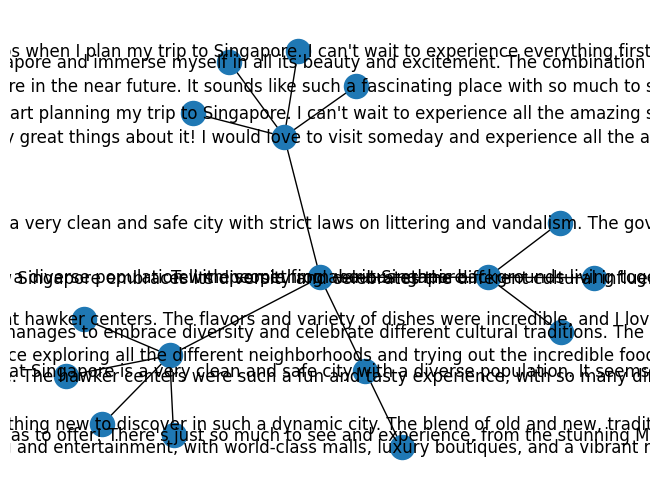

In [ ]:
nx.draw(G, with_labels=True)

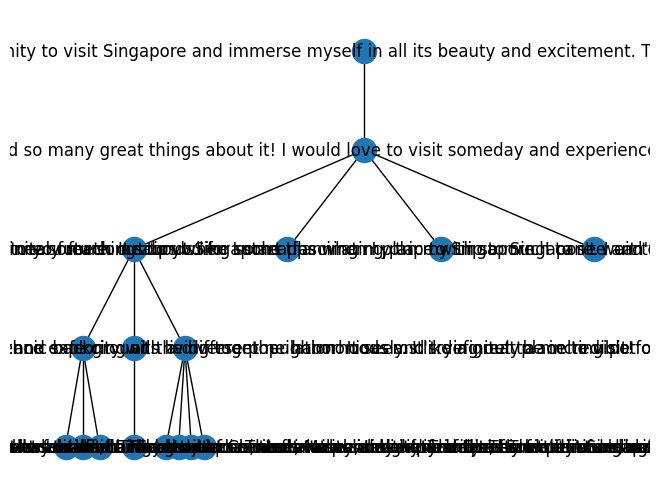

In [ ]:
pos=hierarchy_pos(G,)
nx.draw(G, pos=pos, with_labels=True)

In [ ]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [5]:

conversation_data = pd.read_parquet('data/human_llm_convo.parquet', engine='auto')
english_convo = conversation_data.loc[conversation_data['language'] == "English"]
long_convo = english_convo.loc[english_convo['turn'] > 2]
from data_preprocessing import *
scores = retrieve_openai_moderation(long_convo)


# just take scores

In [ ]:
X = [s[0] for s in scores]
y_harass = [float(s[1]) for s in scores]
y_hate = [float(s[3]) for s in scores]
y_sexual = [float(s[8]) for s in scores]
y_violence = [float(s[10]) for s in scores]

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_sexual,bins=50)


In [ ]:
from torch.utils.data import random_split
from reward_model.toxicity_data import ToxicityData
import pickle

for y, name in zip([y_harass, y_hate, y_sexual, y_violence], ["sentence_harass", "sentence_hate", "sentence_sexual", "sentence_violence"]):
    dataset = ToxicityData(X, y)
    train_size = int(0.8 * len(dataset))  # 80% for training
    val_size = len(dataset) - train_size  # Remaining 20% for validation

    # # Split the dataset randomly
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    #Save the dataset object
    with open('data/toxicity_data/'+name+'_train.pkl', 'wb') as f:
        pickle.dump(train_dataset, f)
        
    with open('data/toxicity_data/'+name+'_validation.pkl', 'wb') as f:
        pickle.dump(val_dataset, f)

In [6]:
def get_scores_threshold(scores, threshold, field):
    # y_harass = [float(s[1]) for s in scores]
    # y_hate = [float(s[3]) for s in scores]
    # y_sexual = [float(s[8]) for s in scores]
    # y_violence = [float(s[10]) for s in scores]
    if field == "harass":
        scores = [s for s in scores if float(s[1]) > 0.001]
        X = [s[0] for s in scores]
        y_harass = [float(s[1]) for s in scores]
        return X, y_harass
    if field == "hate":
        scores = [s for s in scores if float(s[3]) > 0.001]
        X = [s[0] for s in scores]
        y_harass = [float(s[3]) for s in scores]
        return X, y_harass
    if field == "sexual":
        scores = [s for s in scores if float(s[8]) > 0.001]
        X = [s[0] for s in scores]
        y_harass = [float(s[8]) for s in scores]
        return X, y_harass
    if field == "violence":
        scores = [s for s in scores if float(s[10]) > 0.001]
        X = [s[0] for s in scores]
        y_harass = [float(s[10]) for s in scores]
        return X, y_harass

def convert_to_classification(y, threshold):
    y = [0 if score < threshold else 1 for score in y]
    return y



In [7]:
from torch.utils.data import random_split
from reward_model.toxicity_data import ToxicityData
import pickle

for field in ["harass", "hate", "sexual", "violence"]:
    X, y = get_scores_threshold(scores, 0.0001, field)
    y = convert_to_classification(y, 0.05)
    dataset = ToxicityData(X, y)
    train_size = int(0.8 * len(dataset))  # 80% for training
    val_size = len(dataset) - train_size  # Remaining 20% for validation

    # # Split the dataset randomly
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    #Save the dataset object
    with open('data/toxicity_data_classification/'+field+'_train.pkl', 'wb') as f:
        pickle.dump(train_dataset, f)
        
    with open('data/toxicity_data_classification/'+field+'_validation.pkl', 'wb') as f:
        pickle.dump(val_dataset, f)

In [3]:
from reward_model.sentence_toxicity_model import SentenceToxicClassifierModel
from torch.utils.data import DataLoader
from reward_model.toxicity_data import ToxicityData
import pickle
import torch

with open('data/toxicity_data_classification/sexual_train.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open('data/toxicity_data_classification/sexual_train.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

from transition_models.deterministic_transition_model import DeterministicTransitionModel

device = torch.device('cuda:4')
model = SentenceToxicClassifierModel(cuda=device)
t,v = model.train(train_loader, val_loader, path_to_save="models/classification_test", lr=0.00002, num_epochs=200)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


getting validation loss...
Epoch 1/200, Train Loss: 0.21623689, Validation Loss: 0.20048040,Validation Acc: 0.91930796,
saving model...
getting validation loss...
Epoch 2/200, Train Loss: 0.18405150, Validation Loss: 0.13039571,Validation Acc: 0.95585115,
getting validation loss...
Epoch 3/200, Train Loss: 0.08697376, Validation Loss: 0.07757820,Validation Acc: 0.97607985,
getting validation loss...
Epoch 4/200, Train Loss: 0.08580805, Validation Loss: 0.04784200,Validation Acc: 0.98624194,
getting validation loss...
Epoch 5/200, Train Loss: 0.00979716, Validation Loss: 0.02339001,Validation Acc: 0.99387941,


KeyboardInterrupt: 

In [1]:
from reward_model.sentence_toxicity_model import SentenceToxicClassifierModel, SentenceToxicRegressionModel
from torch.utils.data import DataLoader
from reward_model.toxicity_data import ToxicityData
import pickle
import torch

with open('data/toxicity_data/sentence_sexual_train.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

with open('data/toxicity_data/sentence_sexual_train.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

device = torch.device('cuda:4')
model = SentenceToxicRegressionModel(cuda=device)
t,v = model.train(train_loader, val_loader, path_to_save="models/regression_test", lr=0.000002, num_epochs=200)


/home/chenzhil/miniconda3/envs/convPlan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chenzhil/miniconda3/envs/convPlan/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


getting validation loss...
Epoch 1/200, Train Loss: 0.12469172, Validation Loss: 0.14748825,
saving model...
getting validation loss...
Epoch 2/200, Train Loss: 0.12242273, Validation Loss: 0.14737812,
getting validation loss...
Epoch 3/200, Train Loss: 0.17213133, Validation Loss: 0.14738178,
getting validation loss...
Epoch 4/200, Train Loss: 0.13811019, Validation Loss: 0.14723971,
getting validation loss...
Epoch 5/200, Train Loss: 0.16258831, Validation Loss: 0.14726634,
getting validation loss...
Epoch 6/200, Train Loss: 0.17944439, Validation Loss: 0.14735386,
getting validation loss...
Epoch 7/200, Train Loss: 0.13930844, Validation Loss: 0.14737182,
getting validation loss...
Epoch 8/200, Train Loss: 0.18090916, Validation Loss: 0.14721397,
getting validation loss...
Epoch 9/200, Train Loss: 0.15625548, Validation Loss: 0.14720069,
getting validation loss...
Epoch 10/200, Train Loss: 0.11124489, Validation Loss: 0.14719383,
getting validation loss...
Epoch 11/200, Train Loss: 

In [1]:
import openai
import yaml
from agent.Agent import *

human, llm_agent = create_human_and_llm()

/home/chenzhil/miniconda3/envs/convPlan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Initialized Human as local model: meta-llama/Meta-Llama-3-8B-Instruct.
Initialized LLM as local model: meta-llama/Meta-Llama-3-8B-Instruct.


In [2]:
convo = Conversation("Hi, how are you?")
llm_agent.sample_actions(convo)

["I'm doing well, thanks for asking! I've been learning a lot about the world and its many wonders. Did you know that there's a",
 "I'm functioning within optimal parameters, thanks for asking! I've been processing a vast amount of text data and generating responses to various prompts. It's",
 "I'm just a language model, I don't have feelings like humans do, but I'm functioning properly and ready to chat! Did you know that",
 "I'm functioning within optimal parameters, thank you for asking! I've been processing a vast amount of text data and generating responses with precision. But I",
 "I'm doing well, thanks for asking! I've been processing a vast amount of text data and learning new patterns and relationships. It's a never"]

In [12]:
convo = Conversation("Hi, how are you?")
llm_agent.sample_actions(convo)

["I'm doing well, thanks for asking! I've been learning a lot about the world and its many wonders. Did you know that there's a",
 "I'm functioning within optimal parameters, thanks for asking! I've been processing a vast amount of text data and generating responses to various prompts. It's",
 "I'm just a language model, I don't have feelings like humans do, but I'm functioning properly and ready to chat! Did you know that",
 "I'm functioning within optimal parameters, thank you for asking! I've been processing a vast amount of text data and generating responses with precision. But I",
 "I'm doing well, thanks for asking! I've been processing a vast amount of text data and learning new patterns and relationships. It's a never"]

In [11]:
convo = Conversation("Hi, how are you?")
llm_agent.sample_actions(convo)

["I'm doing well, thanks for asking! I've been learning a lot about the world and its many wonders. Did you know that there's a",
 "I'm functioning within optimal parameters, thanks for asking! I've been processing a vast amount of text data and generating responses to various prompts. It's",
 "I'm just a language model, I don't have feelings like humans do, but I'm functioning properly and ready to chat! Did you know that",
 "I'm functioning within optimal parameters, thank you for asking! I've been processing a vast amount of text data and generating responses with precision. But I",
 "I'm doing well, thanks for asking! I've been processing a vast amount of text data and learning new patterns and relationships. It's a never"]

In [10]:
r1==r2

True